# 1 Introduction

Diabetes is a growing problem in the US. According to the CDC, 34.2 million Americans have this disease. This amounts to 10.5% of the total US population. Of these, only 26.9 million Americans have been diagnosed, leaving 7.3 million diabetic Americans (21.4% of all diabetic Americans) undiagnosed. In addition to the health risks, the CDC estimates that between 2012 and 2017, the excess medical costs associated with diabetes increased from $\$ $8,417 to $\$ $9,601 per capita. Moreover, the trend for diabetes in the US continues to increase.

In light of the health risks that come from diabetes, it is of paramount importance to catch this disease as soon as possible. However, the cost of such a test ranges between $\$ $176 to $\$ $236. It thus becomes necessary to develop a model for predicting diabetes that both minimizes the number of false negatives (for health reasons) and false positives (for financial reasons) and also maximizes the number of true negatives (also for financial reasons).

These optimizations translate to maximizing both the recall and precision of our model. However, in this context, recall is much more important as a low recall score would mean that many people are not getting the medical attention they need.

# 2 Importing the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
raw_df = pd.read_csv('Data/diabetes.csv')

In [3]:
raw_df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


We can see that there are zeroes in many of the columns. Assuming that Glucose, BloodPressure, Insulin, BMI, DiabetesPedigreeFuction, and Age should be nonzero, we interpret these zeroes as missing data points.

# 3 Imputing the Missing Data

Text(0.5, 0, 'Feature')

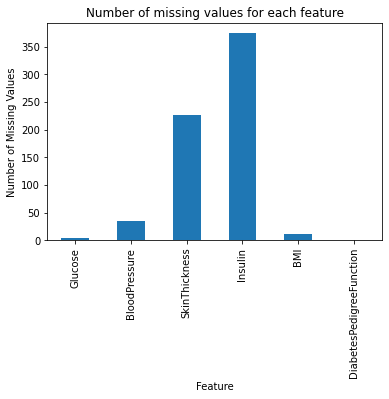

In [4]:
((raw_df == 0).sum())[1:7].plot.bar()

plt.title('Number of missing values for each feature')
plt.ylabel('Number of Missing Values')
plt.xlabel('Feature')

SkinThickness and Insulin have significant missing data.

In [5]:
df = raw_df.copy()
df[df.iloc[:, 1:7]==0] = np.nan

Replace all zeroes in the columns for Glucose to Age with NaN. These missing values will pose a serious challenge for out prediction models, particularly for Insulin and SkinThickness. Therefore we will not use these two columns in our analysis and will instead use the others (Pregnancies, Glucose, BloodPressure, BMI, DiabetesPedigreeFunction, and Age) with missing values imputed with the mean.

In [6]:
df = df[['Pregnancies', 'Glucose', 'BloodPressure',
         'BMI','DiabetesPedigreeFunction', 'Age', 'Outcome']].fillna(df.mean(axis=0))

# 4 Data Visualization

## 4.1 Distribution of Outcomes

We take a look at how skewed the results for the diabetes results are:

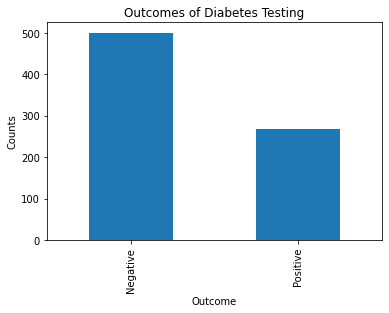

In [7]:
D = df.Outcome.value_counts()
D.index = ['Negative', 'Positive']
D.plot.bar()

plt.xlabel('Outcome')
plt.ylabel('Counts')
plt.title("Outcomes of Diabetes Testing")
plt.show()

It is clear that, although the data is skewed towards negative results, it is not skewed in a significant way (approximately a 2:1 ratio).

## 4.2 Correlation Matrix


We now take a look at the correlations between the various features and target.

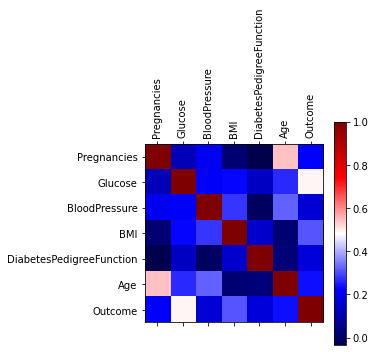

In [8]:
data = df.corr()

plt.matshow(data, cmap="seismic")
plt.xticks(range(len(df.columns)), df.columns, rotation='vertical')
plt.yticks(range(len(df.columns)), df.columns)

plt.colorbar()
plt.show()

We see that there is high correlation between Glucose and Outcome and also between Pregnancies and Age. We take a look at the numbers for correlation with Outcome.

In [9]:
data.Outcome.sort_values(ascending=False)

Outcome                     1.000000
Glucose                     0.492928
BMI                         0.311924
Age                         0.238356
Pregnancies                 0.221898
DiabetesPedigreeFunction    0.173844
BloodPressure               0.166074
Name: Outcome, dtype: float64

The features with highest correlation with Outcome are Glucose and BMI.

## 4.3 Conditional Distributions of Features and Pairs of Features

We use seaborn to create scatter plots of pairs of features, color-coding by the Outcome. This allows us to inspect the distributions of pairs of variables for both diabetic and non-diabetic patients.

Here are some things that we should notice:
- The conditional distributions, conditioned on the Outcome, for Pregnancies, Glucose, and Age are noticably different for each value of Outcome.
- Many of the conditional distributions for non-diabetic patients are approximately normal or lognormal. For example, both Glucose and BloodPressure are very close to normal distributions for non-diabetic patients.
- The two conditional distributions for Glucose have significant non-overlap. This makes it a variable that is very useful in predicting diabetes as already shown by its high correlation (0.493) with Outcome.

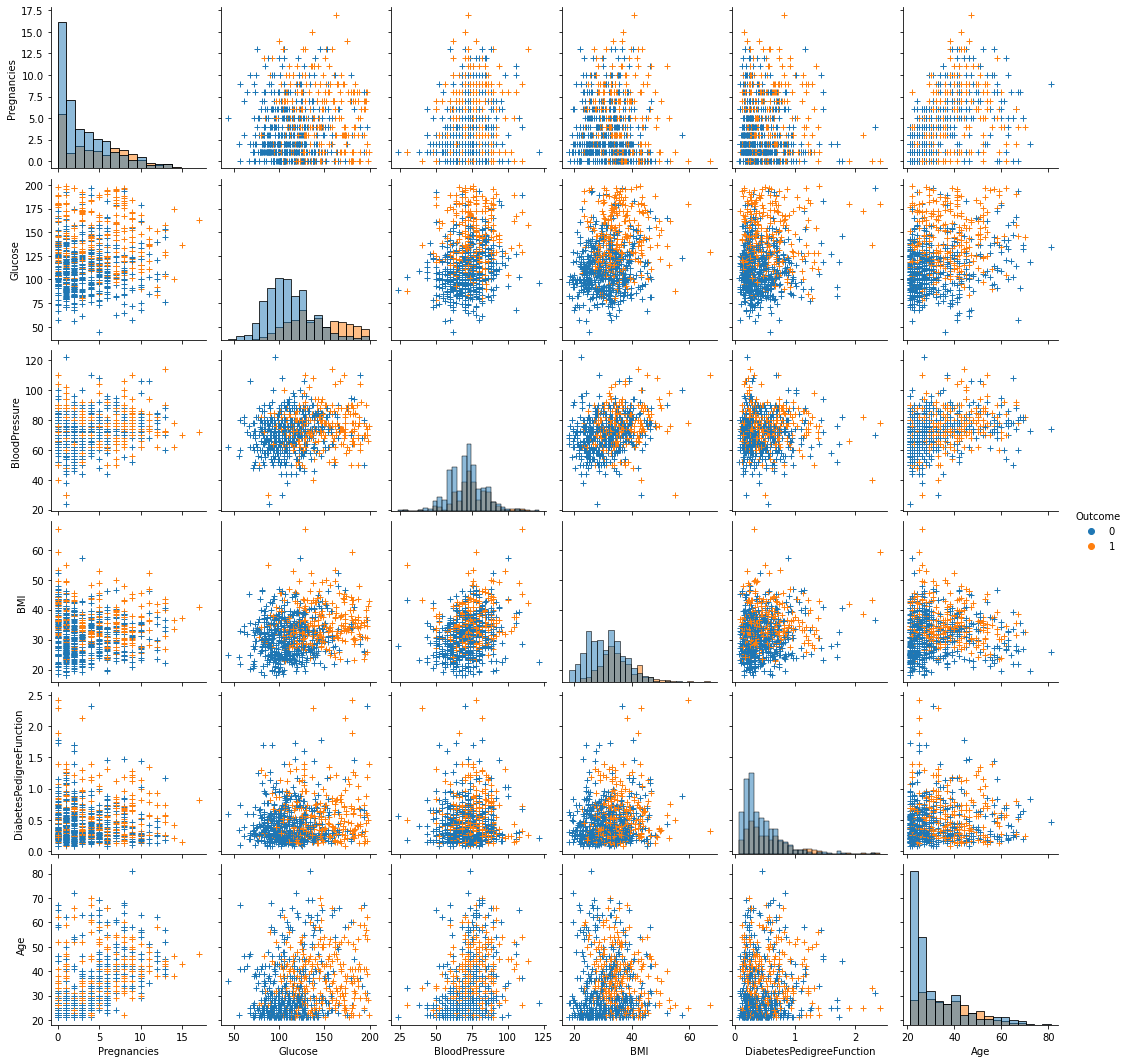

In [10]:
import seaborn as sb

sb.pairplot(df,
            hue='Outcome',
            plot_kws=dict(marker="+", linewidth=1),
            diag_kind = 'hist')
plt.show()

We can take a closer look at some of the more prominent plots. We first consider Glucose versus BMI.

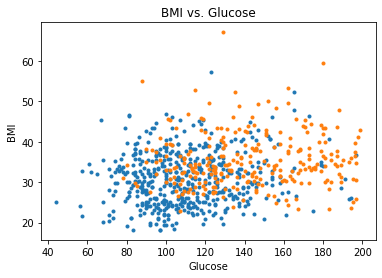

In [11]:
for i in range(2):
    plt.scatter(df[df.Outcome==i].Glucose, df[df.Outcome==i].BMI, marker = '.')
    
plt.xlabel("Glucose")
plt.ylabel("BMI")
plt.title("BMI vs. Glucose")
plt.show()

It looks as if the pair of BMI and Glucose is approximately a joint normal distribution. This is helpful to know as it appears a logistic regression will be a good model, if we were only given Glucose and BMI.

The same can be said of Glucose and Blood Pressure: they are approximately a joint normal distribution with noticiable differences in the mean if separated by the Outcome:

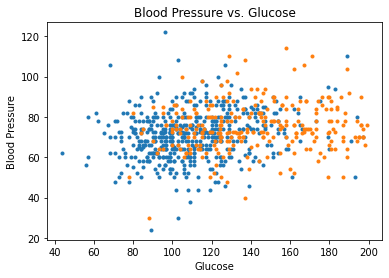

In [12]:
for i in range(2):
    plt.scatter(df[df.Outcome==i].Glucose, df[df.Outcome==i].BloodPressure, marker = '.')
    
plt.xlabel("Glucose")
plt.ylabel("Blood Pressure")
plt.title("Blood Pressure vs. Glucose")
plt.show()

To better understand the differences between the conditional distributions for each of the features, we can plot the normalized histograms: for each of the following plots, the blue and orange histograms each represent the frequencies for measures in a particular Outcome class.

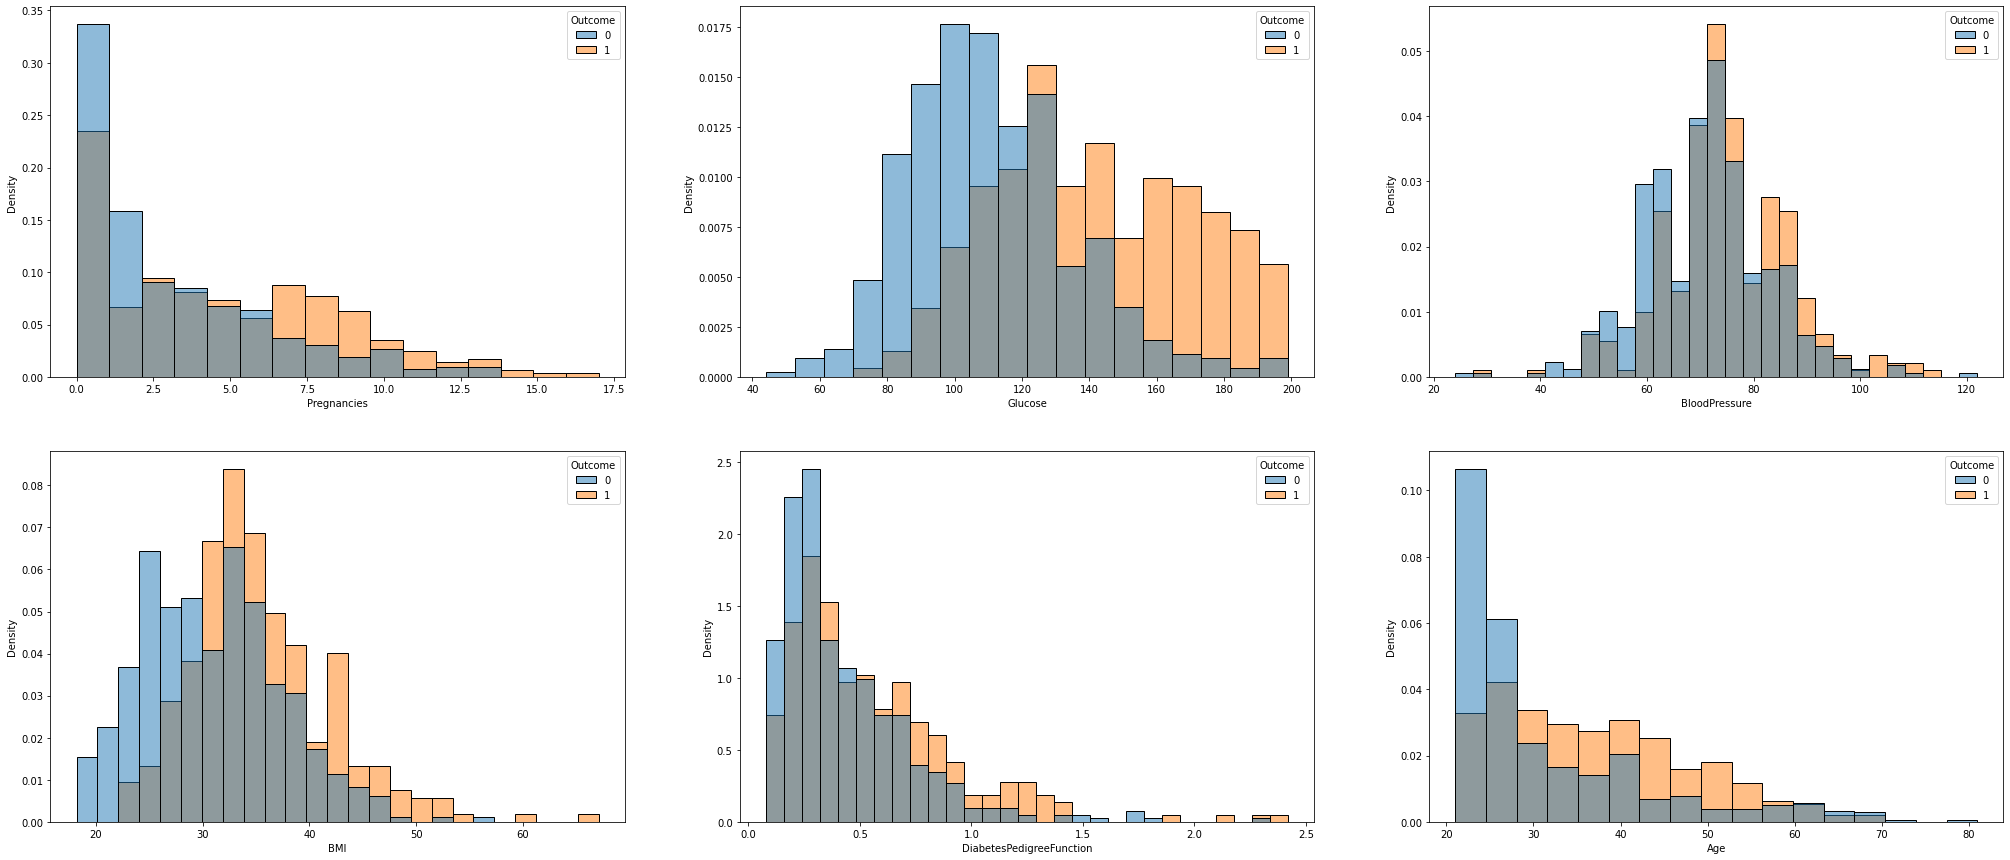

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(35,15))
for i in range(6):
    sb.histplot(df,
                x=df.columns[i],
                hue='Outcome',
                stat='density',
                common_norm=False,
                ax=axs[i//3][i%3])


Here, we have plotted the normalized histograms for each of the features, conditioned on Outcome. Here we have accentuated the differences in the distributions: it is now clear that the means for the distributions of each column are different.

## 4.4 Understanding the Differences between the Conditional Distributions.

Next, we take a look at the distributions of Glucose for each of the Outcomes.

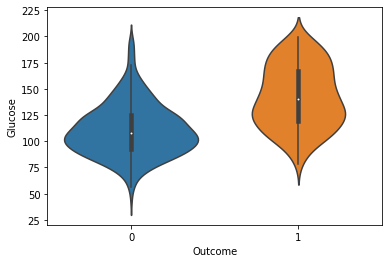

In [14]:
ax = sb.violinplot(x='Outcome', y = 'Glucose', data=df)

Glucose levels are lower for patients without diabetes than those with diabetes. Furthermore, the glucose levels of patients without diabetes has a much lower variance than the glucose levels of patients with diabetes. Let's look at the distributions for BMI conditioned on outcome.

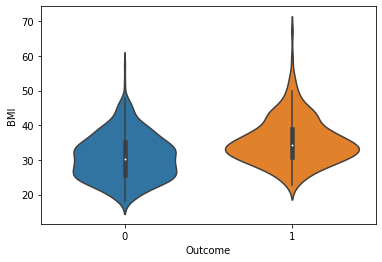

In [15]:
ax = sb.violinplot(x='Outcome', y='BMI', data=df)

The same is still true: in general, patients without diabetes have a higher BMI than those without diabetes. However, the standard deviation of the BMI for patients without diabetes is much higher than the BMI of patients with diabetes.

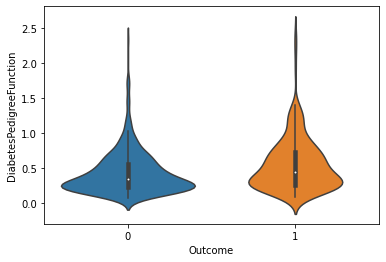

In [16]:
ax = sb.violinplot(x='Outcome', y='DiabetesPedigreeFunction', data=df)

For the DiabetesPedigreeFunction, the relationship is much less pronounced. We will take a look at the numbers to discern a relationship.

In [17]:
df.groupby('Outcome')['DiabetesPedigreeFunction'].describe()

,count,mean,std,min,25%,50%,75%,max
Outcome,,,,,,,,
0,500.0,0.429734,0.299085,0.078,0.22975,0.336,0.56175,2.329
1,268.0,0.550500,0.372354,0.088,0.26250,0.449,0.72800,2.420


The mean DPF for those with diabetes (0.5505) is higher than the mean DPF for those without diabetes (0.4297). This makes sense as diabetes has a genetic factor and the DPF is relates family history to the likelihood that diabetes will affect an individual.

Also notice that, for patients without diabetes, there are many more outliers than those with diabetes. However, this is most likely caused exacerbated by the skewedness of the test results.

We also found that the PDF had one of the weakest correlations with the Outcome (0.1738).

# 5 Feature selection

In order to use the data given to develop a prediction model, we wish to select those features which are best able to predict the Outcome. For this, we use an F-test.

In [18]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

fvalue_selector = SelectKBest(f_classif, k=3)
X_kbest = fvalue_selector.fit_transform(df[['Pregnancies',
                              'Glucose',
                              'BloodPressure',
                              'BMI',
                              'DiabetesPedigreeFunction',
                              'Age']],
                         df.Outcome)

print("k best features: ", X_kbest)

k best features:  [[148.   33.6  50. ]
 [ 85.   26.6  31. ]
 [183.   23.3  32. ]
 ...
 [121.   26.2  30. ]
 [126.   30.1  47. ]
 [ 93.   30.4  23. ]]


## 5.1 Principal Component Analysis

We scale each feature so that the mean is 0 and the standard deviation is 1.

In [19]:
X_df = df.iloc[:, 0:-1]
y_df = df.Outcome

In [20]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_df)
X_df = scaler.transform(X_df)

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 5)
pca.fit(X_df)
X_df = pca.transform(X_df)

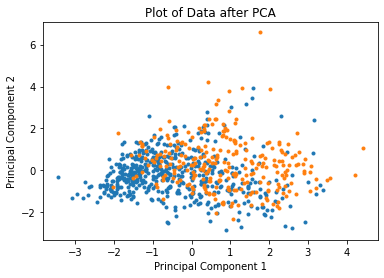

In [22]:
for i in range(2): 
    plt.scatter(X_df[y_df==i, 0], X_df[y_df==i, 1], marker = '.')
    
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Plot of Data after PCA")
plt.show()

In [23]:
sum(pca.explained_variance_ratio_)

0.9312139488295331

Thus, the first 5 principal components explain 93.1% of the variance in the data.

# 6 Data Analysis and Predictions

The next step is to split the data into two sets: the training set and the test set. Once we have these, we can fit our models onto the training set and predict the Outcomes for the test set. Using these actual and predicted values for the test set, we can analyze how well our model handled the predictions.

In [24]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size = 0.2, random_state = 0)

## 6.1 Scoring Functions

We first write a function that calculates and prints the confusion matrix of any given model and returns the recall, precision and accuracy scores in a dictionary.

As a reminder, the confusion matrix is given by
$$
C = 
\left(
\begin{array}{cc}
    \text{True Negatives} && \text{False Positives}\\
    \text{False Negatives} && \text{True Positives}
\end{array}
\right)
=\left(
\begin{array}{cc}
    TN && FP\\
    FN && TP
\end{array}
\right)
$$

We also have
$$
\text{Accuracy} = \frac{\text{Correct Predictions}}{\text{All Predictions}} = \frac{TP + TN}{TP+FP+TN+FN}
$$
and
$$
\text{Recall} = \frac{\text{True Positives}}{\text{Actual Positives}} = \frac{TP}{TP+FN}
$$
and
$$
\text{Precision} = \frac{\text{True Positives}}{\text{Predicted Positives}} = \frac{TP}{TP+FP}.
$$

In [25]:
from sklearn.metrics import confusion_matrix

def score_classifier(clf, X_train, y_train, X_test, y_test, print_table=True):
    fitted_clf = clf.fit(X_train, y_train)
    y_pred = fitted_clf.predict(X_test)
    
    score = fitted_clf.score(X_test, y_test)
    cm = confusion_matrix(y_test, y_pred, labels = [0, 1])
    
    recall = cm[1,1]/(cm[1,1] + cm[1, 0])
    precision = cm[1,1]/(cm[1,1] + cm[0, 1])
    if(print_table):
        print("\tConfusion Matrix:\t" + str(cm).replace('\n', '\n\t\t\t\t'))
        print("\tAccuracy:\t" + str(score))
        print("\tRecall:\t\t" + str(recall))
        print("\tPrecision:\t" + str(precision))
    return {'Confusion Matrix': cm, 'Accuracy': score, 'Recall': recall, 'Precision': precision}

The models that we will use are listed as follows:

1. Decision Tree Classifier    
2. Gaussian Naive Bayes Classifier
3. Logistic Regression
4. K-Nearest Neighbors Classifier
5. Support Vector Classifier
    
We will discuss each of these separately.

We will also write a function that makes it easier to plot the scores for a given model for a range of parameter values. For instance, the following function can be used with the $k$-nearest neighbor model to plot the scores, recalls, and precisions for different values of $k$.

In [26]:
def plot_scores_by_parameters(results, parameter, m=2, M=50, step=1, fs=(30,30)):
    scores = []
    recalls = []
    precisions = []
    for x in results:
        scores.append(x['Accuracy'])
        recalls.append(x['Recall'])
        precisions.append(x['Precision'])
    
    fig, axs = plt.subplots(figsize=fs)
    
    plt.plot(np.arange(m,M,step), scores, marker = '.', label='Accuracy')
    plt.plot(np.arange(m,M,step), recalls, marker = '.', label='Recall')
    plt.plot(np.arange(m,M,step), precisions, marker = '.', label='Precision')

    plt.xlabel(parameter)
    plt.ylabel("Precision/Recall/Accuracy")
    plt.title("Scores vs "+parameter)
    plt.legend()

    plt.show()

### Cross-Validation

The following function will print the mean accuracy, recall, and precision after splitting the data for cross-validation.

In [27]:
from sklearn.model_selection import cross_validate

def cross_validation_arp(clf, X_data, y_data, cv):
    cv_scores = cross_validate(clf, X_data, y_data, cv=cv, scoring = ('accuracy', 'recall', 'precision'))
    print("Mean Accuracy:\t" + str(cv_scores['test_accuracy'].mean()))
    print("Mean Recall:\t" + str(cv_scores['test_recall'].mean()))
    print("Mean Precision:\t" + str(cv_scores['test_precision'].mean()))

## 6.2 Decision Tree Classifier

### 6.2.1 Description

A Decision Tree Classifier (DTC) seeks to classify data points based on conditions which its features satisfy. That is, a DTC can be represented as a tree where, starting at the root node, questions about a specific feature are asked and the answer determines which child node to consider next. There are many such trees, however algorithms seeking to model data using a decision tree minimize either the entropy of the tree or the gini index of the tree, both of which are measures for the information gained at each level of the tree.

In [28]:
from sklearn.tree import DecisionTreeClassifier

dtc = DecisionTreeClassifier(criterion="gini", max_depth=5)
score = score_classifier(dtc, X_train, y_train, X_test, y_test)
print(score)

	Confusion Matrix:	[[82 25]
				 [ 7 40]]
	Accuracy:	0.7922077922077922
	Recall:		0.851063829787234
	Precision:	0.6153846153846154
{'Confusion Matrix': array([[82, 25],
       [ 7, 40]]), 'Accuracy': 0.7922077922077922, 'Recall': 0.851063829787234, 'Precision': 0.6153846153846154}


### 6.2.2 Varying the Maximum Depth

We can vary the maximum depth on our decision tree to determine how each constraint performs.

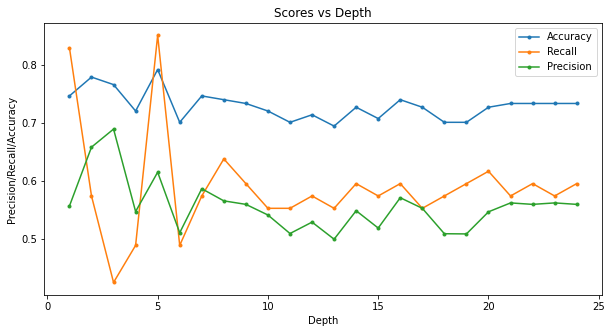

In [29]:
DTC_res = []
M = 25
for i in range(1, M):
    DTC_res.append(score_classifier(DecisionTreeClassifier(max_depth=i), X_train, y_train, X_test, y_test, print_table=False))
plot_scores_by_parameters(DTC_res, 'Depth', 1, M, 1, (10,5))

From this plot, it is clear that the best model occurs at a maximum depth of 5. The maximum accuracy and maximum recall occur at maximum depth 5.

### 6.2.3 Cross-Validation

In [30]:
tree_clf = DecisionTreeClassifier(max_depth=5)
cross_validation_arp(tree_clf, X_df, y_df, cv=10)

Mean Accuracy:	0.6991626794258373
Mean Recall:	0.5297720797720797
Mean Precision:	0.5796077004655852


The DTC gave a recall of approximately 0.85 above. However, after validation, we see that this was specific only to the test set that we happened to split our data and the generalized recall for this model is much lower.

## 6.3 Gaussian Naive Bayes Classifier

### Description

The Gaussian Naive Bayes (NB) Classifier looks to classify a data point given by $(x_1,\dots, x_N)$ into one of $K$ categories, denoted $C_k$ $k=1,\dots, K$. The main assumption here is that each of the features $x_i$ are independent and normally distributed. As data is collected, it is possible to fit a normal distribution onto each of the features by calculating the sample mean $\mu_i$ and (unbiased) sample variance $\sigma_i^2$. Then, using Bayes' Theorem, the probability $P(C_k|\mathbf{x})$ that a point $\mathbf{x} = (x_1,\dots, x_N)$ belongs to the class $C_k$ is given by
$$
    P(C_k|\mathbf{x}) = \frac{P(C_k)P(\mathbf{x}|C_k)}{P(\mathbf{x})}.
$$

Here,

* $P(C_k)$ denotes the relative frequency of the class $C_k$ in the training set,
* $P(\mathbf{x}|C_k)$ denotes the probability of observing $\mathbf{x}$ given that the data point was a part of class $C_k$,
* and $P(\mathbf{x})$ denotes the probability of observing $\mathbf{x}$.

From the assumption that all features are independent, we see that

$$
    P(C_k|\mathbf{x}) = \frac{P(C_k)\cdot \prod_{i=1}^N P(x_i|C_k)}{P(\mathbf{x})}.
$$

The NB Classifier then predicts that $\vec{x}$ belongs to the class $C_k$ which maximizes $P(C_k|\mathbf{x})$, that is, $$
    \text{predicted class for $\mathbf{x}$} = \mathrm{argmax}_{C_k} P(C_k)\cdot \prod_{i=1}^N P(x_i|C_k),
$$
where we have ommitted the factor of $P(\mathbf{x})$ since it is common to all $P(C_k|\mathbf{x})$.

In [31]:
from sklearn.naive_bayes import GaussianNB
score = score_classifier(GaussianNB(), X_train, y_train, X_test, y_test)

	Confusion Matrix:	[[92 15]
				 [21 26]]
	Accuracy:	0.7662337662337663
	Recall:		0.5531914893617021
	Precision:	0.6341463414634146


## 6.4 Logistic Regression

### 6.4.1 Description
Logistic regression seeks to classify data into binary categories, say $C_0$ and $C_1$, by associating the value of $y=0$ to the class $C_0$ and the value $y=1$ to the class $C_1$ and fitting a curve, with parameters $\pmb{\theta}$ and $\theta_0$, of the form
$$
    y = \frac{1}{1-e^{-\pmb{\theta}^T\mathbf{x}-\theta_0}}.
$$
The value of $y$ can be interpreted as giving the probability $P(C_1|\mathbf{x})$ that a data point $\mathbf{x}$ lies within class $C_1$.

In [32]:
from sklearn.linear_model import LogisticRegression
score = score_classifier(LogisticRegression(penalty='l2'), X_train, y_train, X_test, y_test)

	Confusion Matrix:	[[96 11]
				 [20 27]]
	Accuracy:	0.7987012987012987
	Recall:		0.574468085106383
	Precision:	0.7105263157894737


### 6.4.2 Varying the Threshold
By default, a data point $\mathbf{x}$ is classified into $C_1$ if $P(C_1|\mathbf{x}) > 0.5$ and $C_0$ otherwise.

If this threshold value $\alpha = 0.5$ is varied, then a data point $\mathbf{x}$ will be more likely or less likely to be classified into class $C_1$. For diabetes prediction, a question concerning health, if $P(C_1|\mathbf{x})$ is slightly less than 0.5, say 0.45, then it would be a good choice for a patient to take a more precise test to determine if a patient has diabetes.

For each threshold value $\alpha$, we plot the accuracy, recall, and precision scores for the logistic regression.

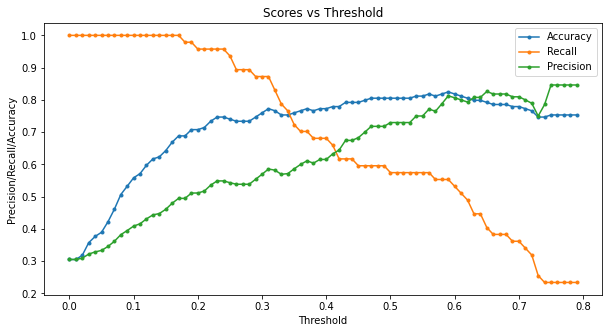

In [33]:
LogReg_res = []
m=0
M=0.8
step=0.01
for i in np.arange(m,M,step):
    LogReg_res.append(score_classifier(LogisticRegression(penalty='l2', class_weight={0:i, 1:1-i}),
                                       X_train, y_train, X_test, y_test, print_table=False))
plot_scores_by_parameters(LogReg_res, 'Threshold', m, M, step, (10,5))

Note that as $\alpha$ increases from 0 to 1, a patient is less likely to be classified as having diabetes, hence the recall decreases. Likewise, as $\alpha$ increases, the accuracy and precision tend to increase.

Around $\alpha = $ 0.25, there is an elbow in the accuracy score, while the precision score plateaus for values from 0.25 to 0.35.

### 6.4.3 Matthews Correlation Coefficient

Another measure of the quality of a model is the Matthews Correlation Coefficient (MCC). This is defined to be
$$
MCC = \frac{TP\cdot TN - FP\cdot FN}{\sqrt{(TP+FP)(TP+FN)(TN+FN)(TN+FP)}}
$$

The MCC returns a value between -1 and 1. A value of $MCC=1$ is perfect prediction and $MCC=0$ indicates that the model is no better than random.

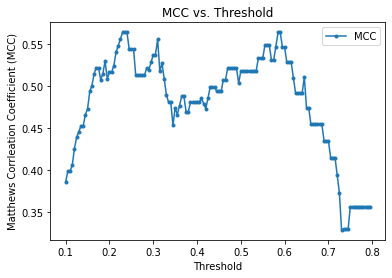

In [34]:
from sklearn.metrics import matthews_corrcoef

LogReg_MCC = []
m=0.1
M=0.8
step=0.005
for i in np.arange(m,M,step):
    lreg = LogisticRegression(penalty='l2', class_weight={0:i, 1:1-i})
    lreg.fit(X_train, y_train)
    y_pred = lreg.predict(X_test)
    LogReg_MCC.append(matthews_corrcoef(y_pred, y_test))
    
plt.plot(np.arange(m,M,step), LogReg_MCC, marker = '.', label='MCC')

plt.xlabel("Threshold")
plt.ylabel("Matthews Corrleation Coefficient (MCC)")
plt.title("MCC vs. Threshold")
plt.legend()

plt.show()

We see a local maximum in the Matthews Correlation Coefficient around $\alpha=$ 0.25 and $\alpha=$0.6. Since, we are prioritizing recall over precision, $\alpha=$0.25 is optimal for the training set.

### 6.4.4 Cross-Validation

In [35]:
logreg_clf = LogisticRegression(penalty='l2', class_weight = {0:0.25, 1:0.75})
cross_validation_arp(logreg_clf, X_df, y_df, cv=10)

Mean Accuracy:	0.7162166780587833
Mean Recall:	0.84002849002849
Mean Precision:	0.5667546110495145


## 6.5 K-Nearest Neighbors Classifier

### 6.5.1 Description

The $k$-Nearest Neighbors (KNN) Classifier is an algorithm with a single integer parameter $k\ge 1$.

Given $k\ge 1$ and training data $x_1,\dots, x_N\in\mathbb{R}^d$, that is, there are $d$ features for the data and $N$ sample points, along with labels $y_1,\dots, y_N$ for each of the $N$ sample points, we wish to make a prediction about a new data point $x_{new}$. The KNN algorithm does this by calculating the distance from $x_{new}$ to each of the points $x_i$, $i=1,\dots, N$, and classifies the point $x_{new}$ into the class given by majority vote of the $k$ points $x_i$ which are closest to $x_{new}$.

There are a few concerns that need to be addressed:

1. What distance metric should be used? Typically the Euclidean $L^2$ metric is used, but there are many other options, such as the Manhattan metric ($L^1$) or the $L^\infty$ metric.
2. The feature data must be scaled to ensure that all features carry the same weight when calculating distance. For instance, if one feature has a small variance while another had a relatively large variance, then the first feature would not contribute much to calculating the distance and so would be relatively ignored in KNN.

### 6.5.2 Varying the number of neighbors

To address these concerns, we will be scaling the feature data of both the training and test set so that each feature has mean 0 and standard deviation 1. As for the distance to be used, we will use the standard Euclidean metric.

In [36]:
from sklearn.neighbors import KNeighborsClassifier
score = score_classifier(KNeighborsClassifier(n_neighbors=5), X_train, y_train, X_test, y_test)
print(score)

	Confusion Matrix:	[[86 21]
				 [18 29]]
	Accuracy:	0.7467532467532467
	Recall:		0.6170212765957447
	Precision:	0.58
{'Confusion Matrix': array([[86, 21],
       [18, 29]]), 'Accuracy': 0.7467532467532467, 'Recall': 0.6170212765957447, 'Precision': 0.58}


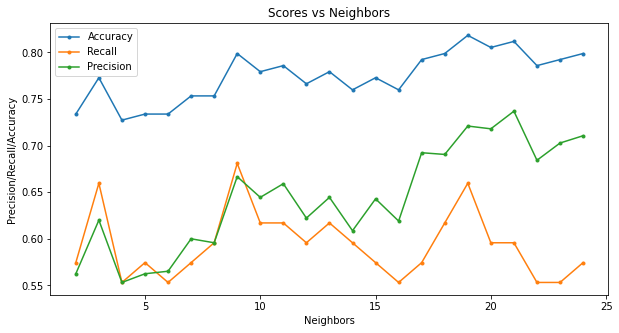

In [37]:
KNN_res = []
m=2
M=25
for i in range(m, M):
    KNN_res.append(score_classifier(KNeighborsClassifier(weights="distance", n_neighbors=i), X_train, y_train, X_test, y_test, print_table=False))
plot_scores_by_parameters(KNN_res, 'Neighbors', m, M, 1, (10,5))

An examination of the plot shows that the recall is maximized at $k=9$.

In [38]:
score_9 = score_classifier(KNeighborsClassifier(n_neighbors=9), X_train, y_train, X_test, y_test)

	Confusion Matrix:	[[92 15]
				 [16 31]]
	Accuracy:	0.7987012987012987
	Recall:		0.6595744680851063
	Precision:	0.6739130434782609


### 6.5.3 Cross-Validation

In [39]:
knn_clf = KNeighborsClassifier(n_neighbors=9)
cross_validation_arp(knn_clf, X_df, y_df, cv=10)

Mean Accuracy:	0.7564935064935066
Mean Recall:	0.5821937321937323
Mean Precision:	0.6906442989415125


## 6.6 Support Vector Classifier

### 6.6.1 Description

Support Vector Classifiers (SVC) seek to divide a set of data into two classes by via a line. A loss function is defined by penalizing an incorrect classification by an amount proportional to the data point's distance to the line, SVC seeks to minimize this loss function.

In [40]:
from sklearn.svm import SVC
score = score_classifier(SVC(kernel='linear'), X_train, y_train, X_test, y_test)

	Confusion Matrix:	[[96 11]
				 [20 27]]
	Accuracy:	0.7987012987012987
	Recall:		0.574468085106383
	Precision:	0.7105263157894737


Just as with logistic regression, a binary SVC has a hyperparameter in the form of the relative weights of its two classes. We can plot the precision, recall, and accuracy for each value of this hyperparameter $\alpha$ between 0 and 1 to obtain the following plot.

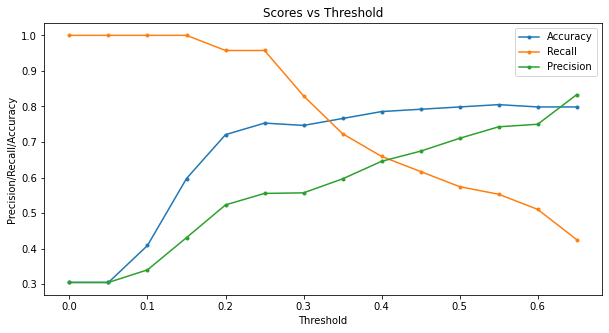

In [48]:
SVC_res = []
m=0
M=0.7
step=0.05
for i in np.arange(m,M,step):
    SVC_res.append(score_classifier(SVC(kernel='linear', class_weight={0:i, 1:1-i}),
                                       X_train, y_train, X_test, y_test, print_table=False))
plot_scores_by_parameters(SVC_res, 'Threshold', m, M, step, (10,5))

The accuracy seems to level off around a threshold of $\alpha=$0.25, while the precision continuouly increases and the recall begins to decrease sharply at this point.

### 6.6.2 Matthews Correlation Coefficient

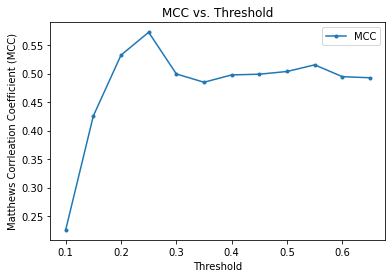

In [49]:
SVC_MCC = []
m=0.1
M=0.7
step=0.05
for i in np.arange(m,M,step):
    svcreg = SVC(kernel='linear', class_weight={0:i, 1:1-i})
    svcreg.fit(X_train, y_train)
    y_pred = svcreg.predict(X_test)
    SVC_MCC.append(matthews_corrcoef(y_pred, y_test))
    
plt.plot(np.arange(m,M,step), SVC_MCC, marker = '.', label='MCC')

plt.xlabel("Threshold")
plt.ylabel("Matthews Corrleation Coefficient (MCC)")
plt.title("MCC vs. Threshold")
plt.legend()

plt.show()

We see that the MCC is maximized at approximately $\alpha=$0.25.

### 6.6.3 Cross-Validation

In [42]:
svc_clf = SVC(kernel='linear', class_weight={0:0.25, 1:0.75})
cross_validation_arp(svc_clf, X_df, y_df, cv=10)

Mean Accuracy:	0.7149008885850991
Mean Recall:	0.8511396011396013
Mean Precision:	0.5627108882962294


## 6.7 Conclusion

We now consider the scores for each of the 5 models described above.

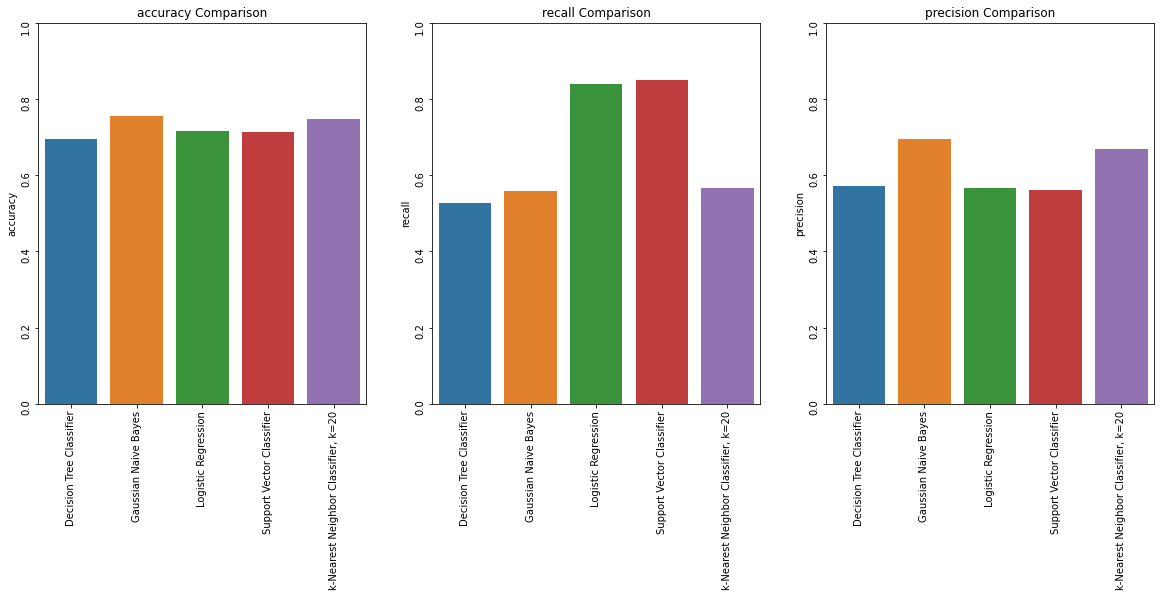

In [43]:
models = [('Decision Tree Classifier', DecisionTreeClassifier(max_depth=5)),
         ('Gaussian Naive Bayes', GaussianNB()),
         ('Logistic Regression', LogisticRegression(penalty='l2', class_weight={0:0.25, 1:0.75})),
         ('Support Vector Classifier', SVC(kernel='linear', class_weight={0:0.25, 1:0.75})),
         ('k-Nearest Neighbor Classifier, k=20', KNeighborsClassifier(weights="distance", n_neighbors=16))]
x = []
y = {'accuracy': [], 'recall': [], 'precision': []}

for name, model in models:
    x.append(name)
    cv_scores = cross_validate(model, X_df, y_df, cv=10, scoring = ('accuracy', 'recall', 'precision'))
    for key in ['accuracy', 'recall', 'precision']:
        y[key].append(cv_scores['test_'+key].mean())

dy = pd.DataFrame(y, index=x)

fig, axs = plt.subplots(ncols=3, figsize=(20,7))
i=0
for col in dy.columns:
    axs[i].tick_params(labelrotation=90)
    axs[i].set_title(dy.columns[i] + " Comparison")
    axs[i].set_ylim((0,1.0))
    sb.barplot(x=dy.index, y=col, data=dy, ax=axs[i])
    i += 1

We see that the accuracy and precision scores are all similar, however, the logistic regression and SVC dominate the recall scores.

Because of the implications of having a low recall (many of those who need medical attention are not getting it) versus those of having a low precision (many people are paying for a test to come up negative), it is much more important for our model to have maximum recall. In light of this, it seems apt to say that the logistic regression and SVC are best to perform these predictive tests.